In [2]:
import sys
print("Python version: {}". format(sys.version))
import pandas as pd
print("pandas version: {}". format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))
import seaborn as sns
import numpy as np
print("numpy version: {}". format(np.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics, svm
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras import Sequential
from keras.activations import sigmoid
import os
le = LabelEncoder()
print('-'*25)
import os
print('\n'.join(os.listdir('input')))
print('-'*25)

Python version: 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
pandas version: 2.1.2
matplotlib version: 3.8.1
numpy version: 1.26.1
sklearn version: 1.3.2
-------------------------
test.csv
train.csv
gender_submission.csv
-------------------------


In [3]:
data_raworig = pd.read_csv("input/train.csv") #raw train data
data_testorig = pd.read_csv("input/test.csv") #Original test data
data_train = data_raworig.copy(deep = True) #Train_data copied to protect raw train data 
data_test = data_testorig.copy(deep = True) #Test_data copied to protect raw test data
Data = [data_train, data_test] #List of both datas to clean them simultaneous
print(data_train.shape)
print(data_test.shape)
print("Check train data:")
data_train.head()


(891, 12)
(418, 11)
Check train data:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Since we have 
    SibSp = Number of Spouse or Siblings
and 
    Parch = Number of Parents and Children for each passanger, 
it seems that a good data to have is Family Size. Lets check it:

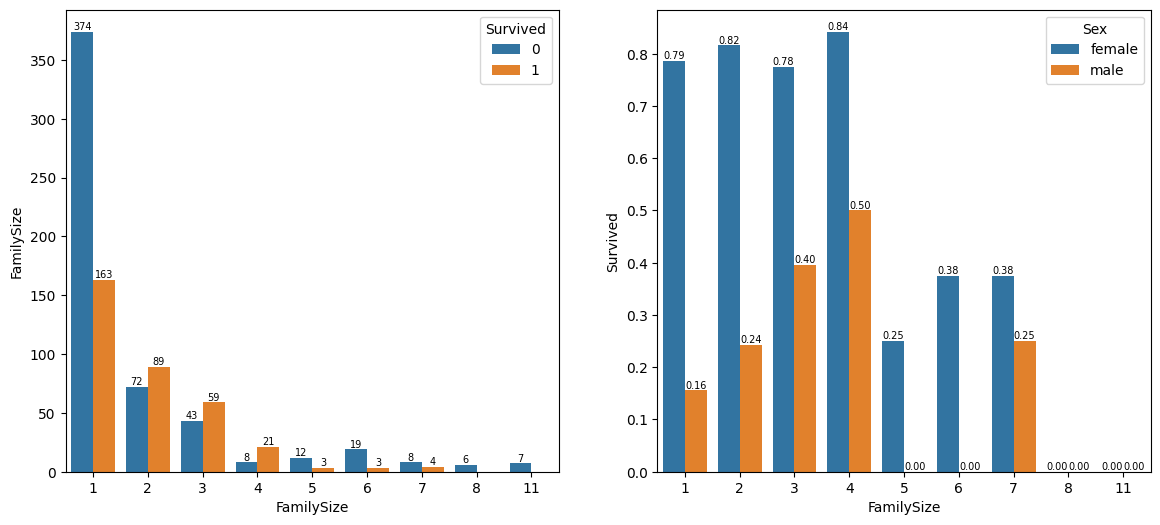

In [4]:
for data in Data: #New variables to analyze
    data["Surname"] = data["Name"].str.split(",", expand=True)[0] #Surname of each passenger
    data["FamilySize"] = data["SibSp"]+data["Parch"]+1 #Family size on board
    data["IsAlone"] = data["FamilySize"].apply(lambda x: 1 if x == 1 else 0) # If alone 1, else 0
    data["Title"] = data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0] #Title of each person (Ex: Mr, Mrs., Miss., etc.)
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(14,6))
plotFamilySurvived1 = sns.barplot(x = "FamilySize", y = "FamilySize", hue = 'Survived', estimator=len, data=data_train, ax=axis1, errorbar=None)
for container in plotFamilySurvived1.containers:
    plotFamilySurvived1.bar_label(container, fmt='%1.0f', fontsize=7);
plotFamilySurvived2 = sns.barplot(data = data_train, x = "FamilySize", y = "Survived", hue = "Sex", errorbar=None, ax = axis2);
for container in plotFamilySurvived2.containers:
    plotFamilySurvived2.bar_label(container, fmt='%1.2f', fontsize=7);

It appears that having a small family (2-4 family size) gives the best outcome to survive. Thus, we should define a variable which helps us identify these cases

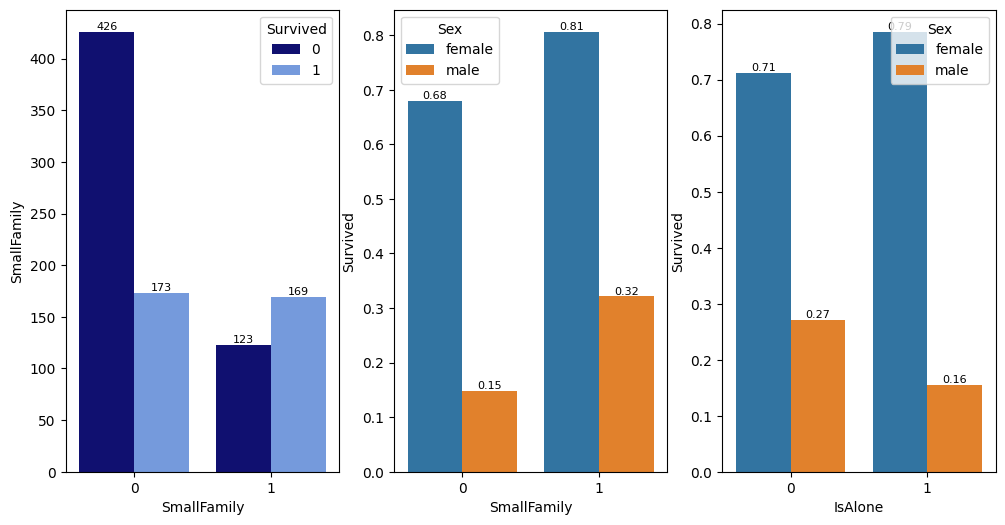

In [5]:
for data in Data:
    data["SmallFamily"] = 0 #Small Family means Family of size between 2 and 4
    data["SmallFamily"] = data["FamilySize"].apply(lambda x: 0 if x == 1 or x > 4 else 1)
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(12,6))
plotSmallFamilySurvived = sns.barplot(x = data_train["SmallFamily"], y = data_train["SmallFamily"], hue = data_train["Survived"], estimator=len, ax=axis1, palette=['navy', 'cornflowerblue'])
for container in plotSmallFamilySurvived.containers:
    plotSmallFamilySurvived.bar_label(container, fontsize=8)
hue_order = ["female", "male"]
plotSmallFamilySurvivedSex = sns.barplot(x = data_train["SmallFamily"], y = data_train["Survived"], hue = data_train["Sex"],hue_order = ["female", "male"], errorbar = None, ax=axis2)
for container in plotSmallFamilySurvivedSex.containers:
    plotSmallFamilySurvivedSex.bar_label(container, fmt='%1.2f', fontsize=8)
plotAloneSurvivedSex = sns.barplot(x = data_train["IsAlone"], y = data_train["Survived"], hue = data_train["Sex"], hue_order = hue_order, errorbar = None, ax=axis3)
for container in plotAloneSurvivedSex.containers:
    plotAloneSurvivedSex.bar_label(container, fmt='%1.2f', fontsize=8)

Thus, it is correct to assume that having an small family improves your chance of survival. In the same vein, for women being alone is better than traveling with a family in general, because larger families had a worse chance to surive. 

We need to fix the database now with the missing values.

In [6]:
print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Surname          0
FamilySize       0
IsAlone          0
Title            0
SmallFamily      0
dtype: int64
-------------------------
Null data in test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
Surname          0
FamilySize       0
IsAlone          0
Title            0
SmallFamily      0
dtype: int64
-------------------------


There are 2 embarked missing on the Train data set. Let see if we can find a correlation between Embarking and Fare/PClass

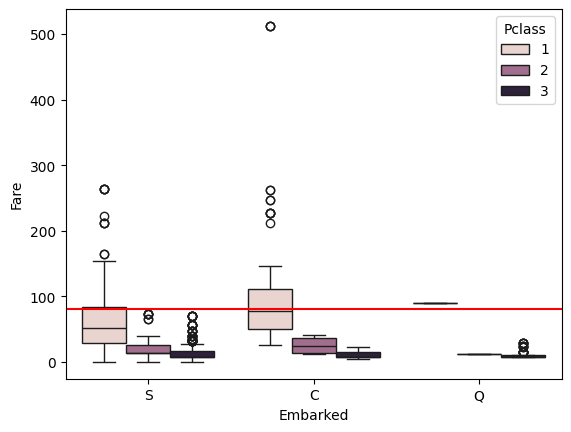

In [7]:
sns.boxplot(data = data_train, x = "Embarked", y = "Fare", hue = "Pclass" )
plt.axhline(80, c='r')

Since they have Pclass = 1 and Fare = 80, we can assume that they Embarked in C.

In [8]:
data_train["Embarked"].fillna("C", inplace = True)

What about Age?. We have 177 missing value on the Train data set. Can we obtain some kind of correlation with Fare and Pclass?

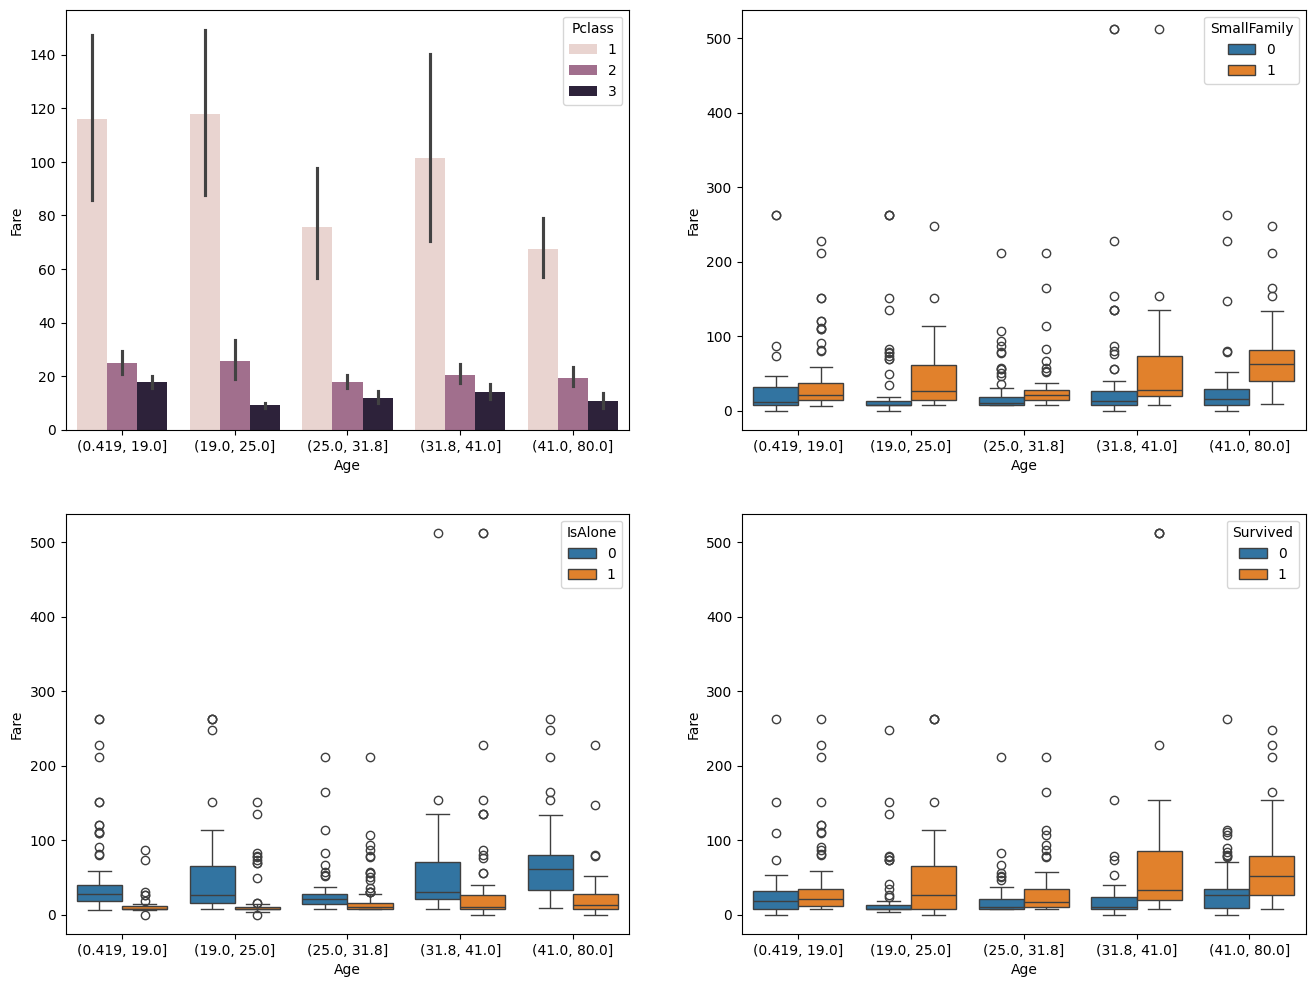

In [9]:
fig, saxis = plt.subplots(2, 2,figsize=(16,12))
sns.barplot(data = data_train, y = "Fare" ,  x = pd.qcut(data_train["Age"], 5), hue = "Pclass", ax = saxis[0,0] )
sns.boxplot(data = data_train, x = pd.qcut(data_train["Age"], 5), y = "Fare", hue = "IsAlone", ax = saxis[1,0] )
sns.boxplot(data = data_train, x = pd.qcut(data_train["Age"], 5), y = "Fare", hue = "SmallFamily", ax = saxis[0,1] )
sns.boxplot(data = data_train, x = pd.qcut(data_train["Age"], 5), y = "Fare", hue = "Survived", ax = saxis[1,1] );

It seems that there is no "smart" way to refill this data. We could try to use some kind of ML to do it. We will separate the age data into categories depending their stage of life, with children, teenagers and women which are young adult have the better survival rates.

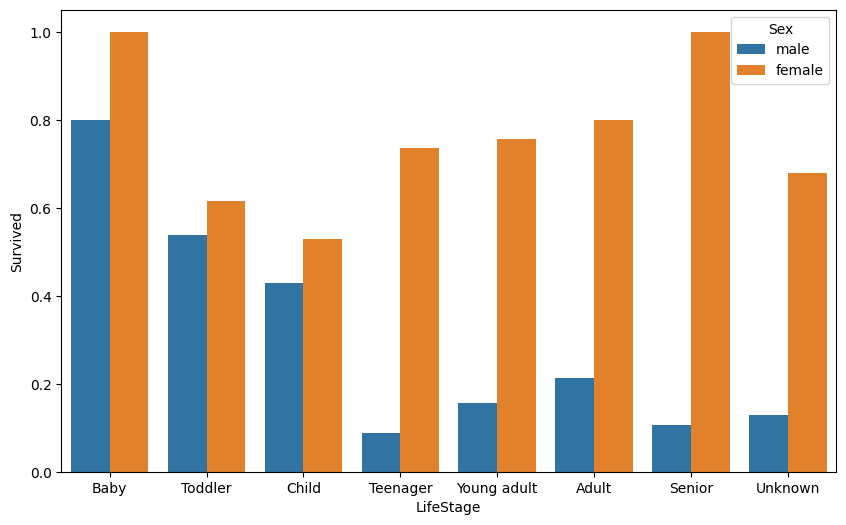

In [10]:
def age_group_name(age):
    a = ""
    if age != age:
        a = "Unknown"
    elif age <= 1:
        a = "Baby"
    elif age <= 4:
        a = "Toddler"
    elif age <=13:
        a = "Child"
    elif age <=18:
        a = "Teenager"
    elif age <=30:
        a = "Young adult"
    elif age <=60:
        a = "Adult"
    else:
        a = "Senior"
    return a
def age_group_number(age):
    a = ""
    if age != age:
        a = -1
    elif age <= 1:
        a = 0
    elif age <= 4:
        a = 1
    elif age <=13:
        a = 2
    elif age <=18:
        a = 3
    elif age <=30:
        a = 4
    elif age <=60:
        a = 5
    else:
        a = 6
    return a
for data in Data:
    data["LifeStage"] = data["Age"].apply(lambda x: age_group_name(x))
fig, ax = plt.subplots(figsize = (10,6))
LifeStageOrder=["Baby", "Toddler", "Child", "Teenager", "Young adult", "Adult", "Senior", "Unknown"]
sns.barplot(data = data_train, x = "LifeStage", y = "Survived", hue = "Sex", order = LifeStageOrder, errorbar=None);

We still need to fix the missing Fare value on the test_data. He is a 60.5 years old male (Senior) of low class (Pclass = 3) which was traveling alone and embarked in Southampton. Thus, lets look at this data:

In [11]:
datad = data_test[data_test["Embarked"]== "S"]
print(datad[datad["Pclass"] == 3].groupby(["Embarked", "Pclass", "LifeStage", "Sex"])["Fare"].mean())
del datad

Embarked  Pclass  LifeStage    Sex   
S         3       Adult        female    12.923600
                               male      13.803289
                  Baby         female    16.486100
                               male      12.508333
                  Child        female    46.900000
                               male      20.295133
                  Senior       male            NaN
                  Teenager     female     9.893750
                               male      19.271350
                  Toddler      female    16.993750
                  Unknown      female    28.341150
                               male      13.434496
                  Young adult  female    12.685788
                               male       9.238351
Name: Fare, dtype: float64


Since he is the only Senior, we will use the Fare of male adults.

In [12]:
data_test["Fare"].fillna(13.803289, inplace = True)
print("Null data on train:")
print(data_train.isnull().sum())
print('-'*25)
print("Null data in test:")
print(data_test.isnull().sum())
print('-'*25)

Null data on train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Surname          0
FamilySize       0
IsAlone          0
Title            0
SmallFamily      0
LifeStage        0
dtype: int64
-------------------------
Null data in test:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Surname          0
FamilySize       0
IsAlone          0
Title            0
SmallFamily      0
LifeStage        0
dtype: int64
-------------------------


There are a lot of missing data on Cabin to try to fix it correctly, thus we will drop it. Now, we will prepare and categorize our data to predict the age of the missing values. We already have categorized the Age and family size data. Let prepare the other important data.

In [13]:
for data in Data:
    data["FareBin"] = pd.qcut(data["Fare"], 5) #Since Fare is float, we use quartile separation to map it to 0,1,2,3
for data in Data: #Gives each value of the variable a Category to give it a numerical value
    data["Sex_Calc"] = le.fit_transform(data["Sex"])
    data["Embarked_Calc"] = le.fit_transform(data["Embarked"])
    data["FareBin_Calc"] = le.fit_transform(data["FareBin"])
    data["LifeStage_Calc"] = data["Age"].apply(lambda x: age_group_number(x))
title_names = (data_train["Title"].value_counts() < 10) #Assigning True to titles which appears less than 10 times
for data in Data:
    data["Title"] = data["Title"].apply(lambda x: "Misc" if x not in title_names or title_names.loc[x] == True else x) #Removing odd title names with True assigned.
    data["Title_Calc"] = le.fit_transform(data["Title"])
Target = ["LifeStage_Calc"]
data_x_calc = ["Pclass", "Sex_Calc", "FamilySize", "IsAlone", "SibSp", "Parch", "SmallFamily", "Embarked_Calc", "FareBin_Calc", "Title_Calc", "LifeStage_Calc"]
#We want to prepare data to compute Age. The strategy is the following: We will merge train+test data, and then separate them depending if LifeStage_Calc has a value or not.
#Then, we will train our model in the joint known data, to then predict separately on the missing data of train and test.
data_test_calc = data_test[data_x_calc].copy(deep = True) #Only the test_data we will use to predict LifeStage_Calc
data_train_calc = data_train[data_x_calc].copy(deep = True) #data_train_age with Survived added
#We join both data to make the prediction
data_calc = pd.concat([data_test_calc, data_train_calc])
#Data on which we know LifeStage_Calc, which is the data on which we will train our model.
data_train_life = data_calc[data_calc["LifeStage_Calc"] != -1]

Let use sklearn to predict the values of the LifeStage_Calc.

In [14]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data_train_life, data_train_life["LifeStage_Calc"])
clf = svm.SVC()
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.9580152671755725


With our trained model ready. We can predict the missing LifeStage of each person and we clean the databases we created to compute this.

In [15]:
data_train_age = data_train_calc[data_train_calc["LifeStage_Calc"] != -1]
data_test_noage = data_train_calc[data_train_calc["LifeStage_Calc"] == -1]
#Final database for train data:
data_train_final = data_train[data_x_calc+["Survived"]].copy(deep = True)
data_train_final.head()
missing_index1 = data_train_final[data_train_final['LifeStage_Calc'] == -1].index
data_train_final.loc[missing_index1, "LifeStage_Calc"] = clf.predict(data_test_noage)

data_test_age = data_test_calc[data_test_calc["LifeStage_Calc"] != -1]
data_test_noage = data_test_calc[data_test_calc["LifeStage_Calc"] == -1]
#Final database for train data:
data_test_final = data_test[data_x_calc].copy(deep = True)
data_test_final.head()
missing_index1 = data_test_final[data_test_final['LifeStage_Calc'] == -1].index
data_test_final.loc[missing_index1, "LifeStage_Calc"] = clf.predict(data_test_noage)


Now that we have fixed the data, we can predict which people survive in the Titanic. We first review our data:

In [16]:
print(data_train_final.shape)
data_train_final.head()

(891, 12)


,Pclass,Sex_Calc,FamilySize,IsAlone,SibSp,Parch,SmallFamily,Embarked_Calc,FareBin_Calc,Title_Calc,LifeStage_Calc,Survived
0,3,1,2,0,1,0,1,2,0,3,4,0
1,1,0,2,0,1,0,1,0,4,4,5,1
2,3,0,1,1,0,0,0,2,1,2,4,1
3,1,0,2,0,1,0,1,2,4,4,5,1
4,3,1,1,1,0,0,0,2,1,3,5,0


In [17]:
print(data_test_final.shape)
data_test_final.head()

(418, 11)


,Pclass,Sex_Calc,FamilySize,IsAlone,SibSp,Parch,SmallFamily,Embarked_Calc,FareBin_Calc,Title_Calc,LifeStage_Calc
0,3,1,1,1,0,0,0,1,1,3,5
1,3,0,2,0,1,0,1,2,0,4,5
2,2,1,1,1,0,0,0,1,1,3,6
3,3,1,1,1,0,0,0,2,1,3,4
4,3,0,3,0,1,1,1,2,2,4,4


In [18]:
data_train_final_x = data_train_final[data_x_calc]
data_train_final_y = data_train_final["Survived"]
model = Sequential()
model.add(Dense(12, input_shape=(11,), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(data_train_final_x, data_train_final_y, epochs=150, batch_size=10, verbose=0)

2023-11-27 17:32:15.728718: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-27 17:32:15.728785: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-27 17:32:15.728803: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-27 17:32:15.729085: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-27 17:32:15.729322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-27 17:32:16.541223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [19]:
_, accuracy = model.evaluate(data_train_final_x, data_train_final_y)
print('Accuracy: %.2f' % (accuracy*100))
print(model.summary())

28/28 [==============================] - 1s 9ms/step - loss: 0.4307 - accuracy: 0.8159
Accuracy: 81.59
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 257 (1.00 KB)
Trainable params: 257 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Now we predict the value of survive for our test data:

In [21]:
predictions = (model.predict(data_test_final) > 0.5).astype(int)

14/14 [==============================] - 3s 71ms/step
